In [38]:
# ============================================================================
# Import Libraries
# ============================================================================
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns



In [39]:
# ============================================================================
# Helper Functions
# ============================================================================

def print_step_header(step_number, step_title, explanation=None):
    print(f"\n{'='*75}")
    print(f"# STEP {step_number}: {step_title}")
    print(f"{'='*75}")
    if explanation:
        print(f"# Explanation: {explanation}")

def print_categorical_summary(df, col):
    """Print summary for a categorical column."""
    unique_count = df[col].nunique()
    null_count = df[col].isnull().sum()
    null_pct = (null_count / len(df)) * 100

    print(f"\n{col}:")
    print(f"  - Unique values: {unique_count:,}")
    print(f"  - Missing values: {null_count:,} ({null_pct:.2f}%)")

    # Show top values based on cardinality
    if unique_count <= 20:
        top_n = 10
        label = "Top values"
    elif unique_count <= 100:
        top_n = 5
        label = "Top 5 values"
    else:
        top_n = 1
        label = "Most frequent"

    value_counts = df[col].value_counts().head(top_n)
    print(f"  - {label}:")
    for val, count in value_counts.items():
        pct = (count / len(df)) * 100
        print(f"    * {val}: {count:,} ({pct:.1f}%)")

    if unique_count > 100:
        print(f"  - Note: High cardinality ({unique_count:,} unique values) - consider grouping for analysis")

def plot_distributions(df, columns, var_type='numeric'):

    if len(columns) == 0:
        return

    n_cols = min(3, len(columns))
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

    # Handle different subplot configurations
    if n_rows == 1 and n_cols == 1:
        # Single subplot: axes is a single Axes object
        axes = [axes]
    elif n_rows == 1:
        # Single row: axes is a 1D array
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    else:
        # Multiple rows: axes is a 2D array
        axes = axes.flatten()

    for idx, col in enumerate(columns):
        ax = axes[idx]

        if var_type == 'numeric':
            # Histogram for numeric variables
            df[col].hist(bins=50, ax=ax, edgecolor='black')
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)

        elif var_type == 'boolean':
            # Bar chart for boolean variables
            value_counts = df[col].value_counts()

            # Use different colors for True/False
            colors = ['#1f77b4' if val else '#ff7f0e' for val in value_counts.index]
            value_counts.plot(kind='bar', ax=ax, edgecolor='black', color=colors)
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.tick_params(axis='x', rotation=0)
            ax.grid(True, alpha=0.3, axis='y')

            # Add percentage labels on bars
            total = len(df[col].dropna())
            for i, (val, count) in enumerate(value_counts.items()):
                pct = (count / total) * 100 if total > 0 else 0
                ax.text(i, count, f'{count:,}\n({pct:.1f}%)',
                       ha='center', va='bottom', fontsize=9)

        elif var_type == 'categorical':
            # Bar chart for categorical variables
            unique_count = df[col].nunique()

            if unique_count <= 20:
                # Show all values
                value_counts = df[col].value_counts()
            else:
                # Show top 10
                value_counts = df[col].value_counts().head(10)

            value_counts.plot(kind='bar', ax=ax, edgecolor='black')
            ax.set_title(f'Distribution of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3, axis='y')

    # Hide unused subplots
    for idx in range(len(columns), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

In [40]:
# ============================================================================
# SECTION 3: DATA UNDERSTANDING
# ============================================================================

# ============================================================================
# STEP 3.1: Collect initial data
# ============================================================================
# Explanation: Collect initial data from Montgomery County Traffic Violations dataset.
print_step_header("3.1", "Collect initial data",
                  "Collect initial data from Montgomery County Traffic Violations dataset.")

random.seed(2025)
np.random.seed(2025)

# Read the data
df = pd.read_csv('TrafficViolations.csv')
print(df.head())



# STEP 3.1: Collect initial data
# Explanation: Collect initial data from Montgomery County Traffic Violations dataset.
                                  SeqID Date Of Stop Time Of Stop Agency  \
0  b4fedce9-1be2-41d0-b600-e2987e079ecd   11/01/2025     06:57:00    MCP   
1  89ddefe5-70f2-4b30-9d60-99ea481a505b   11/01/2025     06:38:00    MCP   
2  3b3f3ef9-b28d-4203-ab65-4b92c9e40748   11/01/2025     06:16:00    MCP   
3  a6b25057-e8a1-4d03-a607-7182574808e6   11/01/2025     06:12:00    MCP   
4  f2191d01-7f2b-4fbd-8e06-97ebd82f1056   11/01/2025     05:59:00    MCP   

                                         SubAgency  \
0  6th District, Gaithersburg / Montgomery Village   
1                           2nd District, Bethesda   
2                      3rd District, Silver Spring   
3                         5th District, Germantown   
4                         5th District, Germantown   

                                         Description  \
0  DRIVING MOTOR VEH. NOT IN ACCORDW/ EQU

In [41]:
# ============================================================================
# STEP 3.2: Describe data
# ============================================================================
# Explanation: Describe dataset characteristics and preliminary exploration
print_step_header("3.2", "Describe data",
                  "Describe dataset characteristics and preliminary exploration")

# Number of records and attributes
print("Dataset Overview:")
print(f"  - Total records: {df.shape[0]:,}")
print(f"  - Total columns: {df.shape[1]}")

# Basic data schema (includes data types, non-null counts and memory usage)
print("\nBasic data schema:")
df.info()

# Also display detailed info for each column (original format)
# print("\nDetailed Column Information (Original Format):")
# print("="*80)
# for col in df.columns:
#     print(f"\nColumn: {col}")
#     print(df[col].describe(include='all'))
#     print("-" * 80)



# STEP 3.2: Describe data
# Explanation: Describe dataset characteristics and preliminary exploration
Dataset Overview:
  - Total records: 2,057,983
  - Total columns: 43

Basic data schema:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057983 entries, 0 to 2057982
Data columns (total 43 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   SeqID                    object 
 1   Date Of Stop             object 
 2   Time Of Stop             object 
 3   Agency                   object 
 4   SubAgency                object 
 5   Description              object 
 6   Location                 object 
 7   Latitude                 float64
 8   Longitude                float64
 9   Accident                 object 
 10  Belts                    object 
 11  Personal Injury          object 
 12  Property Damage          object 
 13  Fatal                    object 
 14  Commercial License       object 
 15  HAZMAT                   object 
 16  Commer

In [42]:
# ============================================================================
# STEP 3.3: Explore data
# ============================================================================
# Explanation: Visualize data, identify relationships among data, query data etc.
print_step_header("3.3", "Explore data",
                  "Visualize data, identify relationships among data, query data etc.")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
bool_cols = df.select_dtypes(include=[bool]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# ============================================================================
# STEP 3.3.1: Statistical summaries
# ============================================================================
# Explanation: Basic statistical analysis for numeric and categorical variables
print_step_header("3.3.1", "Statistical summaries",
                  "Basic statistical analysis for numeric and categorical variables")

# Exclude ID and geolocation tuple columns from analysis
exclude_cols = ['SeqID', 'Geolocation']
analysis_numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
analysis_bool_cols = [col for col in bool_cols if col not in exclude_cols]
analysis_categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# Print numeric columns summary
if len(analysis_numeric_cols) > 0:
    print("\nNumeric Variables Summary:")
    print(df[analysis_numeric_cols].describe())

# Print boolean columns summary
if len(analysis_bool_cols) > 0:
    print("\nBoolean Variables Summary:")
    for col in analysis_bool_cols:
        value_counts = df[col].value_counts()
        total = len(df[col].dropna())
        null_count = df[col].isnull().sum()

        print(f"\n{col}:")
        for val, count in value_counts.items():
            pct = (count / total) * 100 if total > 0 else 0
            print(f"  {val}: {count:,} ({pct:.2f}%)")
        if null_count > 0:
            print(f"  Missing values: {null_count:,} ({(null_count / len(df)) * 100:.2f}%)")

# Print categorical columns summary
print("\nCategorical Variables Summary:")
print(f"Total categorical variables: {len(analysis_categorical_cols)}")
for col in analysis_categorical_cols:
    print_categorical_summary(df, col)


# STEP 3.3: Explore data
# Explanation: Visualize data, identify relationships among data, query data etc.

# STEP 3.3.1: Statistical summaries
# Explanation: Basic statistical analysis for numeric and categorical variables

Numeric Variables Summary:
           Latitude     Longitude          Year
count  2.057983e+06  2.057983e+06  2.047348e+06
mean   3.615751e+01 -7.134010e+01  2.007569e+03
std    1.028911e+01  2.030090e+01  8.511416e+01
min    0.000000e+00 -1.512560e+02  0.000000e+00
25%    3.901650e+01 -7.719289e+01  2.003000e+03
50%    3.906617e+01 -7.708751e+01  2.008000e+03
75%    3.913692e+01 -7.702697e+01  2.013000e+03
max    4.154316e+01  3.906444e+01  9.999000e+03

Boolean Variables Summary:

Contributed To Accident:
  False: 2,001,624 (97.26%)
  True: 56,359 (2.74%)

Categorical Variables Summary:
Total categorical variables: 37

Date Of Stop:
  - Unique values: 5,052
  - Missing values: 0 (0.00%)
  - Most frequent:
    * 03/17/2015: 1,281 (0.1%)
  - Note: High cardinality

In [43]:
# ============================================================================
# 3.3.2: Data visualization
# ============================================================================
# Explanation: Visualize data distributions and relationships
# Organized by priority: focus on most informative variables
print_step_header("3.3.2", "Data visualization",
                  "Visualize data distributions and relationships")

# ============================================================================
# Priority-based variable classification
# ============================================================================
# Classify variables by priority for visualization strategy
priority_1_numeric = analysis_numeric_cols  # All numeric variables
priority_2_categorical_key = []  # Categorical with unique <= 10
priority_3_categorical_medium = []  # Categorical with unique 11-20
priority_4_boolean = analysis_bool_cols  # Boolean variables
priority_5_categorical_high = []  # Categorical with unique > 20 (no plots)

for col in analysis_categorical_cols:
    unique_count = df[col].nunique()
    if unique_count <= 10:
        priority_2_categorical_key.append(col)
    elif 11 <= unique_count <= 20:
        priority_3_categorical_medium.append(col)
    else:
        priority_5_categorical_high.append(col)

print("\n" + "-"*75)
print("Variable Classification by Priority")
print("-"*75)
print(f"Priority 1 - Numeric Variables (All visualized): {len(priority_1_numeric)} variable(s)")
print(f"Priority 2 - Key Categorical Variables (unique ≤ 10, all visualized): {len(priority_2_categorical_key)} variable(s)")
print(f"Priority 3 - Medium Categorical Variables (unique 11-20, selectively visualized): {len(priority_3_categorical_medium)} variable(s)")
print(f"Priority 4 - Boolean Variables (optional visualization): {len(priority_4_boolean)} variable(s)")
print(f"Priority 5 - High Cardinality Categorical Variables (>20 unique, summary only): {len(priority_5_categorical_high)} variable(s)")



# STEP 3.3.2: Data visualization
# Explanation: Visualize data distributions and relationships

---------------------------------------------------------------------------
Variable Classification by Priority
---------------------------------------------------------------------------
Priority 1 - Numeric Variables (All visualized): 3 variable(s)
Priority 2 - Key Categorical Variables (unique ≤ 10, all visualized): 21 variable(s)
Priority 3 - Medium Categorical Variables (unique 11-20, selectively visualized): 2 variable(s)
Priority 4 - Boolean Variables (optional visualization): 1 variable(s)
Priority 5 - High Cardinality Categorical Variables (>20 unique, summary only): 14 variable(s)



---------------------------------------------------------------------------
3.3.2.1: Priority 1 - Distribution of Numeric Variables
         (All numeric variables)
---------------------------------------------------------------------------

Displaying distribution plots for 3 numeric variable(s)...


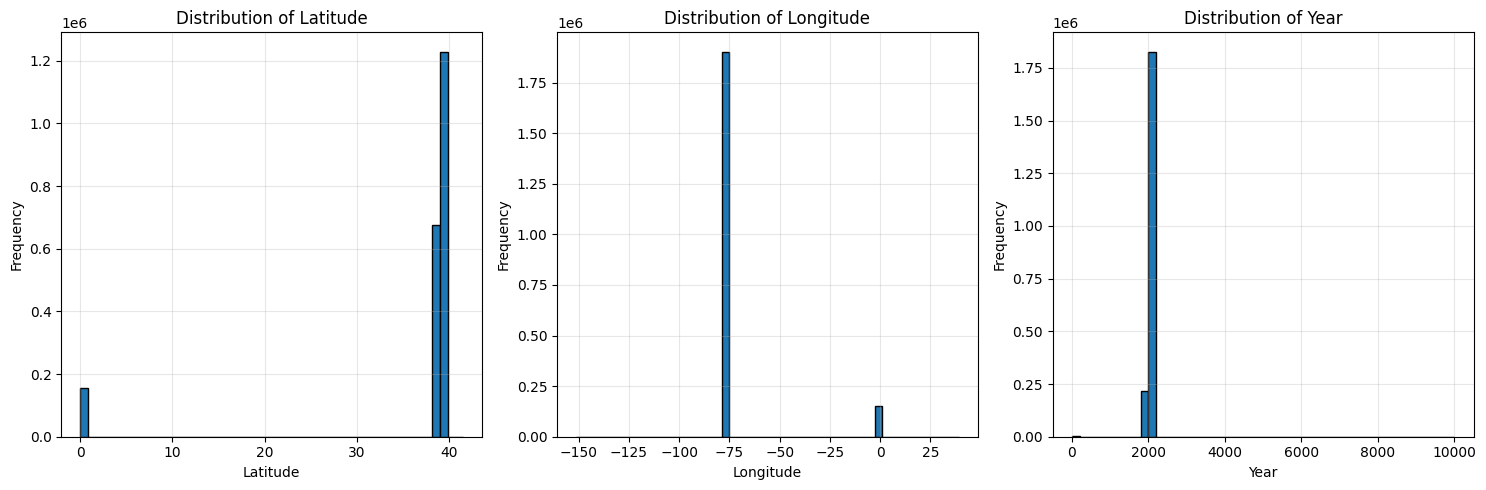

In [44]:
# ============================================================================
# 3.3.2.1: Priority 1 - Numeric Variables
# ============================================================================
# Explanation: Numeric variables are essential for understanding distributions
print("\n" + "-"*75)
print("3.3.2.1: Priority 1 - Distribution of Numeric Variables")
print("         (All numeric variables)")
print("-"*75)
if len(priority_1_numeric) > 0:
    print(f"\nDisplaying distribution plots for {len(priority_1_numeric)} numeric variable(s)...")
    plot_distributions(df, priority_1_numeric, var_type='numeric')
else:
    print("\nNo numeric variables to visualize.")



---------------------------------------------------------------------------
3.3.2.2: Priority 2 - Distribution of Key Categorical Variables
         (Categorical variables with unique ≤ 10)
---------------------------------------------------------------------------

Displaying distribution plots for 21 key categorical variable(s)...


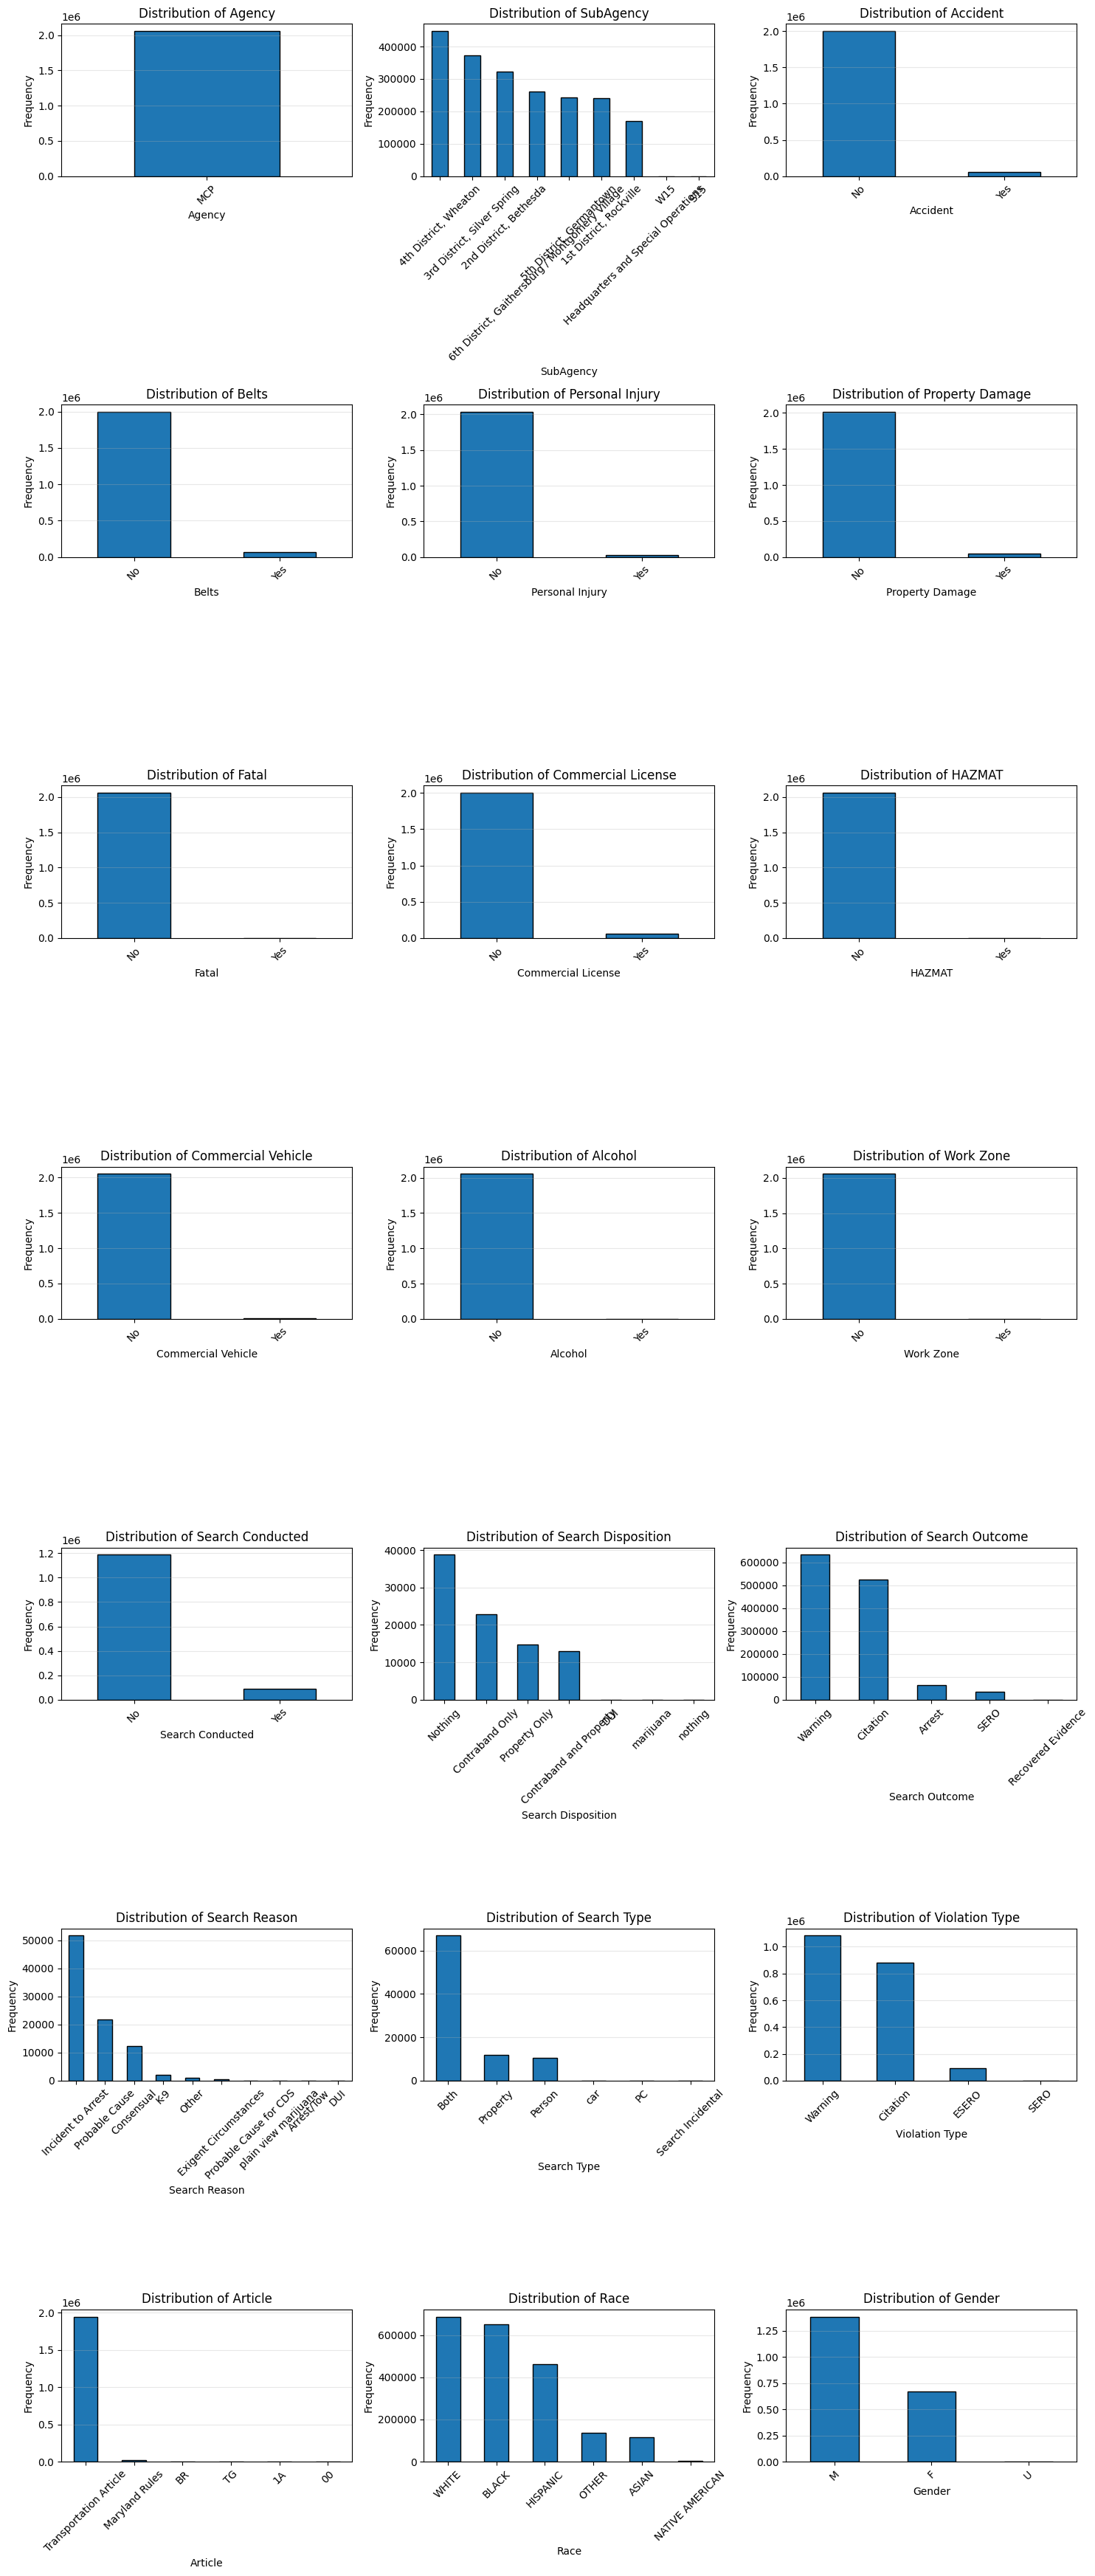

In [45]:
# ============================================================================
# 3.3.2.2: Priority 2 - Key Categorical Variables
# ============================================================================
# Explanation: Categorical variables with <=10 unique values are highly informative
print("\n" + "-"*75)
print("3.3.2.2: Priority 2 - Distribution of Key Categorical Variables")
print("         (Categorical variables with unique ≤ 10)")
print("-"*75)
if len(priority_2_categorical_key) > 0:
    print(f"\nDisplaying distribution plots for {len(priority_2_categorical_key)} key categorical variable(s)...")
    plot_distributions(df, priority_2_categorical_key, var_type='categorical')
else:
    print("\nNo key categorical variables to visualize.")


---------------------------------------------------------------------------
3.3.2.3: Priority 3 - Distribution of Medium Categorical Variables
         (Categorical variables with unique 11-20)
---------------------------------------------------------------------------

Displaying distribution plots for 2 medium categorical variable(s)...
Selected variables: Search Arrest Reason, Arrest Type


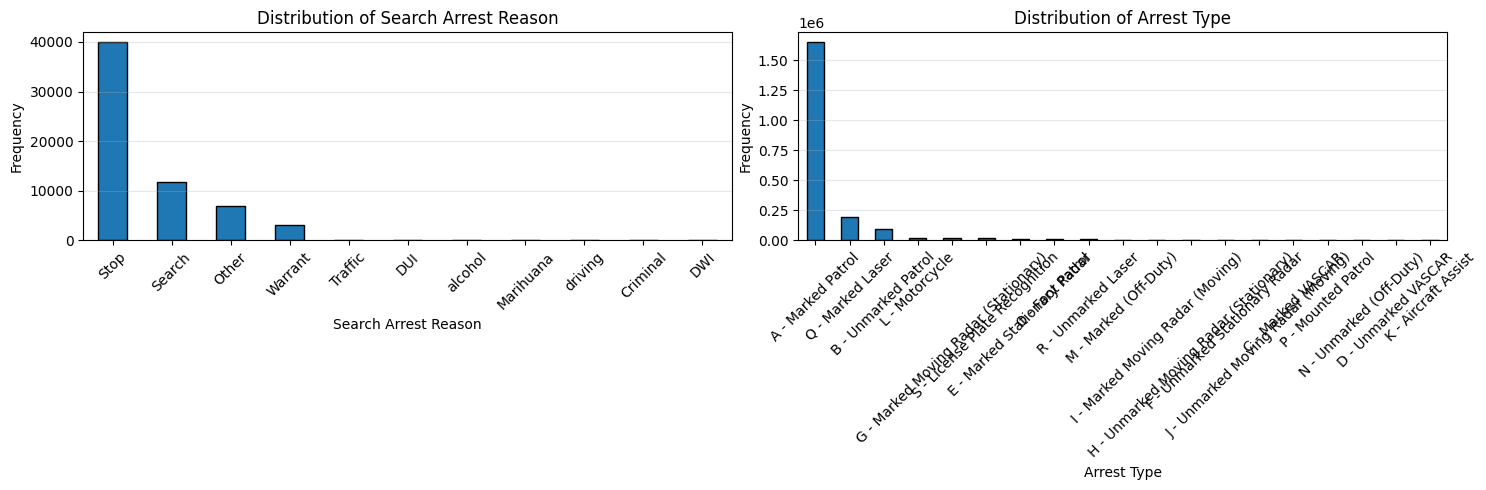

In [46]:
# ============================================================================
# 3.3.2.3: Priority 3 - Medium Categorical Variables
# ============================================================================
# Explanation: Categorical variables with 11-20 unique values (selective visualization)
print("\n" + "-"*75)
print("3.3.2.3: Priority 3 - Distribution of Medium Categorical Variables")
print("         (Categorical variables with unique 11-20)")
print("-"*75)
if len(priority_3_categorical_medium) > 0:
    # For this dataset, we have only 2 variables in this category, so we visualize all
    # In general, you might want to select 5-10 most important ones
    selected_medium = priority_3_categorical_medium  # Select all for this dataset
    print(f"\nDisplaying distribution plots for {len(selected_medium)} medium categorical variable(s)...")
    print(f"Selected variables: {', '.join(selected_medium)}")
    plot_distributions(df, selected_medium, var_type='categorical')
else:
    print("\nNo medium categorical variables to visualize.")


---------------------------------------------------------------------------
3.3.2.4: Priority 4 - Distribution of Boolean Variables
         (Optional visualization, statistical summary is usually sufficient)
---------------------------------------------------------------------------

Displaying distribution plots for 1 boolean variable(s)...
Note: Statistical summary already provided in Step 3.3.1


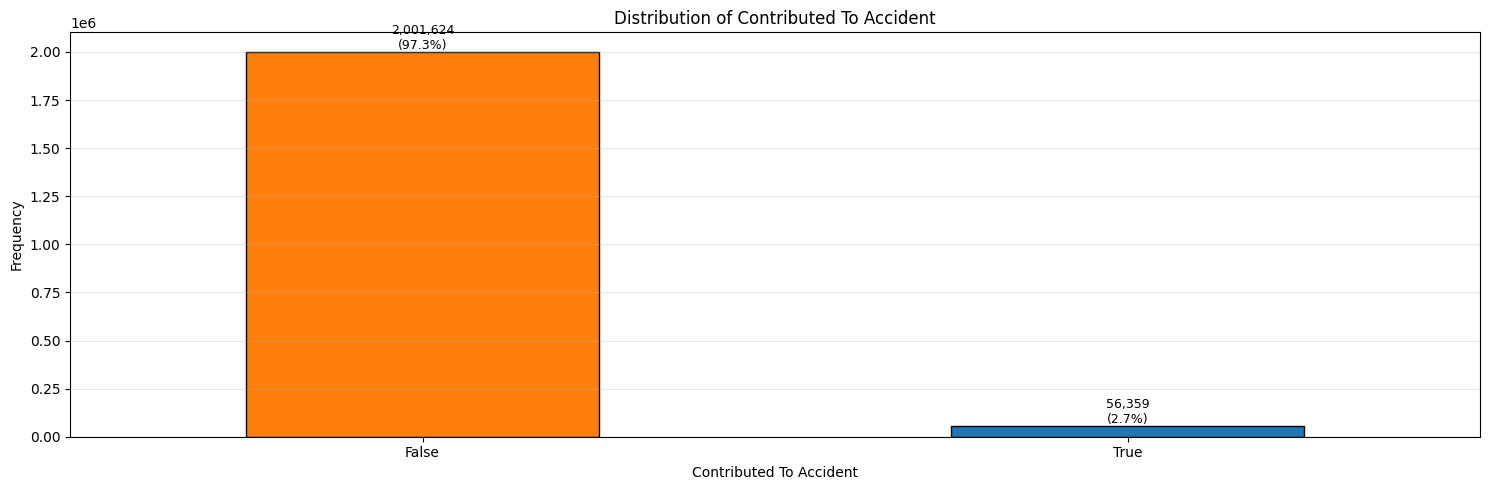

In [47]:
# ============================================================================
# 3.3.2.4: Priority 4 - Boolean Variables
# ============================================================================
# Explanation: Boolean variables (optional visualization - statistical summary is usually sufficient)
print("\n" + "-"*75)
print("3.3.2.4: Priority 4 - Distribution of Boolean Variables")
print("         (Optional visualization, statistical summary is usually sufficient)")
print("-"*75)
if len(priority_4_boolean) > 0:
    print(f"\nDisplaying distribution plots for {len(priority_4_boolean)} boolean variable(s)...")
    print("Note: Statistical summary already provided in Step 3.3.1")
    plot_distributions(df, priority_4_boolean, var_type='boolean')
else:
    print("\nNo boolean variables to visualize.")

In [48]:
# ============================================================================
# 3.3.2.5: Priority 5 - High Cardinality Categorical Variables
# ============================================================================
# Explanation: High cardinality categorical variables are not visualized
# Statistical summaries (from Step 3.3.1) are sufficient for these variables
print("\n" + "-"*75)
print("3.3.2.5: Priority 5 - High Cardinality Categorical Variables")
print("         (No visualization, statistical summary only)")
print("-"*75)
if len(priority_5_categorical_high) > 0:
    print(f"\n{len(priority_5_categorical_high)} high cardinality categorical variable(s) identified.")
    print("These variables are not visualized due to high unique value counts.")
    print("Statistical summaries for these variables are available in Step 3.3.1.")
    print("\nHigh cardinality variables (unique > 20):")
    for col in priority_5_categorical_high:
        unique_count = df[col].nunique()
        print(f"  - {col}: {unique_count:,} unique values")
else:
    print("\nNo high cardinality categorical variables found.")

print("\n" + "="*75)
print("✓ Data visualization completed!")
print("="*75)
print(f"  - Total variables visualized: {len(priority_1_numeric) + len(priority_2_categorical_key) + len(priority_3_categorical_medium) + len(priority_4_boolean)}")
print(f"  - Variables with statistical summary only: {len(priority_5_categorical_high)}")


---------------------------------------------------------------------------
3.3.2.5: Priority 5 - High Cardinality Categorical Variables
         (No visualization, statistical summary only)
---------------------------------------------------------------------------

14 high cardinality categorical variable(s) identified.
These variables are not visualized due to high unique value counts.
Statistical summaries for these variables are available in Step 3.3.1.

High cardinality variables (unique > 20):
  - Date Of Stop: 5,052 unique values
  - Time Of Stop: 1,440 unique values
  - Description: 17,721 unique values
  - Location: 268,060 unique values
  - Search Reason For Stop: 836 unique values
  - State: 72 unique values
  - VehicleType: 36 unique values
  - Make: 4,918 unique values
  - Model: 23,324 unique values
  - Color: 26 unique values
  - Charge: 1,199 unique values
  - Driver City: 9,348 unique values
  - Driver State: 68 unique values
  - DL State: 72 unique values

✓ Data vi